In [3]:
import pandas as pd

CSV_PATH = "/content/customer_booking.csv"
df = pd.read_csv(CSV_PATH, encoding="latin-1")  # latin-1 avoids unicode errors
df.head()


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
TARGET = "booking_complete"
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Target balance:\n", df[TARGET].value_counts(normalize=True))
df.isna().mean().sort_values(ascending=False).head(10)


Shape: (50000, 14)
Columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
Target balance:
 booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64


,0
num_passengers,0.0
sales_channel,0.0
trip_type,0.0
purchase_lead,0.0
length_of_stay,0.0
flight_hour,0.0
flight_day,0.0
route,0.0
booking_origin,0.0
wants_extra_baggage,0.0


In [5]:
ID_COLS = []  # no ID columns

X = df.drop(columns=[TARGET] + ID_COLS)
y = df[TARGET].astype(int)

num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(exclude="number").columns.tolist()

len(num_cols), len(cat_cols)


(8, 5)

In [6]:
TARGET = "booking_complete"
print("Rows, Cols:", df.shape)
print("Target balance:\n", df[TARGET].value_counts(normalize=True))
df.isna().mean().sort_values(ascending=False).head(10)


Rows, Cols: (50000, 14)
Target balance:
 booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64


,0
num_passengers,0.0
sales_channel,0.0
trip_type,0.0
purchase_lead,0.0
length_of_stay,0.0
flight_hour,0.0
flight_day,0.0
route,0.0
booking_origin,0.0
wants_extra_baggage,0.0


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=12,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

model = Pipeline([("pre", pre), ("rf", rf)])
model.fit(Xtr, ytr)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat',
                                                   'wants_in_flight_meals',
                                                   'flight_duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day', 'route',
                                                   'booking_origin'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=12, n_estimators=120,
                                        n_jobs=-1, random_state=42))])

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

proba = model.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "roc_auc": roc_auc_score(yte, proba),
    "accuracy": accuracy_score(yte, pred),
    "f1": f1_score(yte, pred),
    "precision": precision_score(yte, pred),
    "recall": recall_score(yte, pred)
}
metrics


{'roc_auc': np.float64(0.7738677394972358),
 'accuracy': 0.6888,
 'f1': 0.42349018154872176,
 'precision': 0.2929267042542286,
 'recall': 0.7640374331550802}

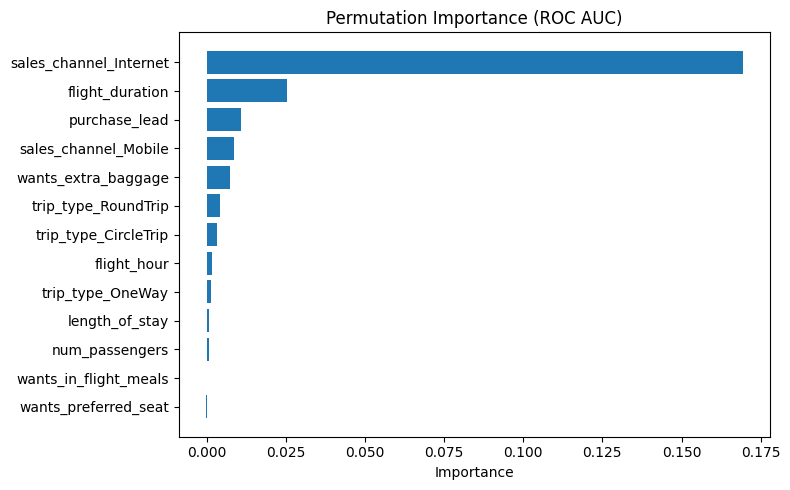

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np, os

res = permutation_importance(model, Xte, yte, scoring="roc_auc",
                             n_repeats=5, random_state=42, n_jobs=-1)  # n_repeats=5 for speed
imps = res.importances_mean

# get post-OHE feature names
ohe = model.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
feat_names = list(num_cols) + list(ohe.get_feature_names_out(cat_cols))

idx = np.argsort(imps)[::-1][:20]
plt.figure(figsize=(8,5))
plt.barh(range(len(idx)), imps[idx])
plt.yticks(range(len(idx)), [feat_names[i] for i in idx])
plt.gca().invert_yaxis()
plt.title("Permutation Importance (ROC AUC)")
plt.xlabel("Importance")
plt.tight_layout()

os.makedirs("/content/reports/figures", exist_ok=True)
plt.savefig("/content/reports/figures/feature_importance.png", dpi=200)
plt.show()


In [10]:
#Need to update data source